In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# RNN for Value Function

In [2]:
from environments.binomials import BinomialBuchbergerEnv, LeadMonomialWrapper

In [3]:
class DegreeAgent:

    def __init__(self, random=False):
        self.random = random

    def act(self, state):
        n = state.shape[2]//2  # number of variables
        degs = np.sum(np.maximum(state[:, :, :n], state[:, :, n:]), axis=2)
        if self.random:
            indices = np.where(degs == np.min(degs))[0]
            return np.random.choice(indices)
        else:
            return np.argmin(degs)

In [4]:
def discounted_rewards(rewards, gamma):
    out = np.empty(len(rewards))
    cumulative_reward = 0
    for i in reversed(range(len(rewards))):
        cumulative_reward = rewards[i] + gamma * cumulative_reward
        out[i] = cumulative_reward
    return list(out)


def train_batched(model, agent, env, episodes, gamma=1.0):
    """Train the value model on the agent's performance."""
    model_loss = 0
    baseline_loss = 0

    total_states = []
    total_actions = []
    total_rewards = []

    # generate rollouts and discounted rewards
    for i in range(episodes):
        state = env.reset()
        done = False
        states = []
        actions = []
        rewards = []
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            states.append(state[:,0,:])
            actions.append(action)
            rewards.append(reward)
            state = next_state
        rewards = discounted_rewards(rewards, gamma)

        total_states += states
        total_actions += actions
        total_rewards += rewards
        
    # process into batches
    batches = {}
    for i in range(len(total_states)):
        size = total_states[i].shape[0]
        if size not in batches:
            batches[size] = [[], []]
        batches[size][0].append(total_states[i])
        batches[size][1].append(total_rewards[i])

    # fit to discounted rewards
    for size in batches:
        states = np.stack(batches[size][0])
        values = np.array(batches[size][1])      
        history = model.fit(states, values, verbose=0)

        model_loss += history.history['loss'][0] * len(batches[size][0])
        baseline_loss += np.sum((values + size)**2)
        
    return model_loss / len(total_states), baseline_loss / len(total_states)

# Example 1

In [5]:
degree = 3
size = 5
variables = 3

env = LeadMonomialWrapper(BinomialBuchbergerEnv(degree, size, variables))

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(None, 2*variables)),
    tf.keras.layers.Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse')

In [6]:
model_losses = []
baseline_losses = []
epochs = 100
for i in range(epochs):
    m, b = train_batched(model, DegreeAgent(), env, 1000)
    model_losses.append(m)
    baseline_losses.append(b)
    print("\rEpoch {}/{} - model: {:.2f} - baseline: {:.2f}".format(i+1, epochs, m, b), end="")

Epoch 100/100 - model: 22.82 - baseline: 70.56

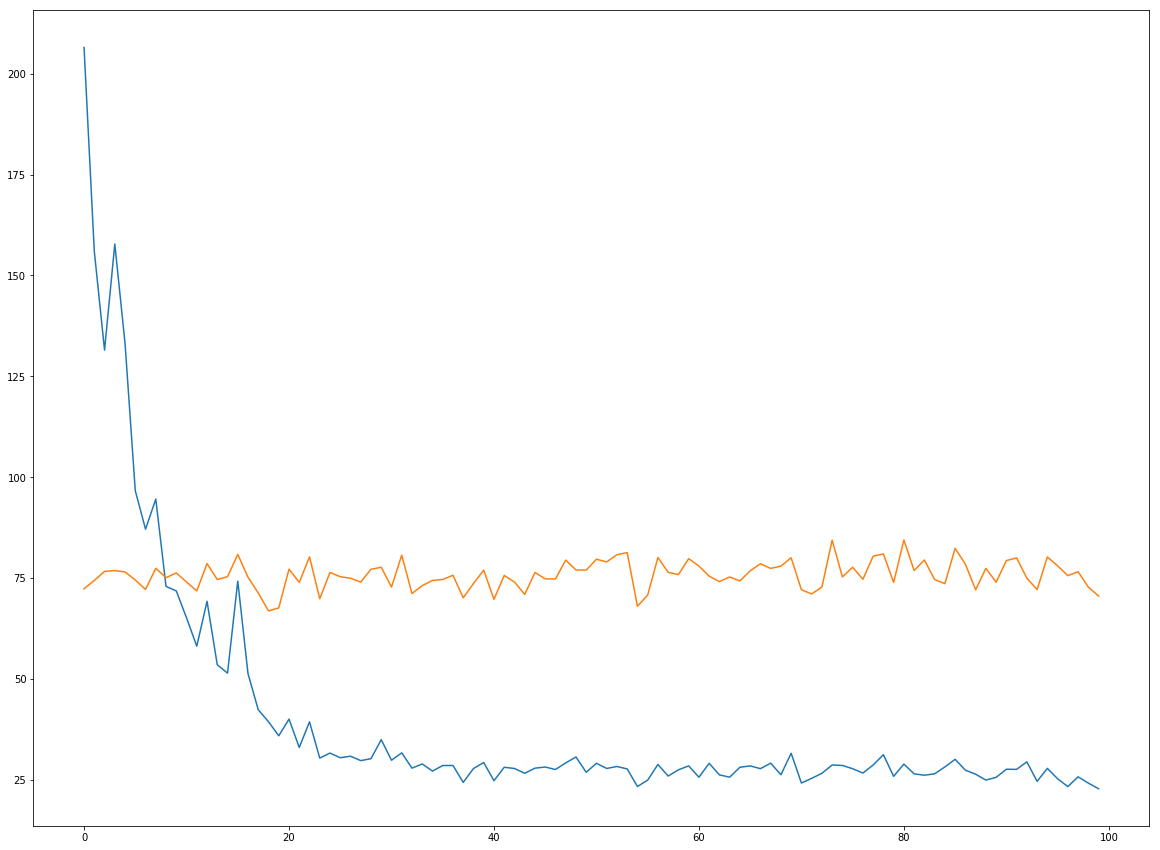

In [7]:
plt.figure(figsize=(20, 15))
plt.plot(model_losses)
plt.plot(baseline_losses)

# Example 2

In [8]:
degree = 5
size = 5
variables = 3

env = LeadMonomialWrapper(BinomialBuchbergerEnv(degree, size, variables), k=2)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(None, 4*variables)),
    tf.keras.layers.Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse')

In [9]:
model_losses = []
baseline_losses = []
epochs = 100
for i in range(epochs):
    m, b = train_batched(model, DegreeAgent(), env, 1000)
    model_losses.append(m)
    baseline_losses.append(b)
    print("\rEpoch {}/{} - model: {:.2f} - baseline: {:.2f}".format(i+1, epochs, m, b), end="")

Epoch 100/100 - model: 208.53 - baseline: 848.34

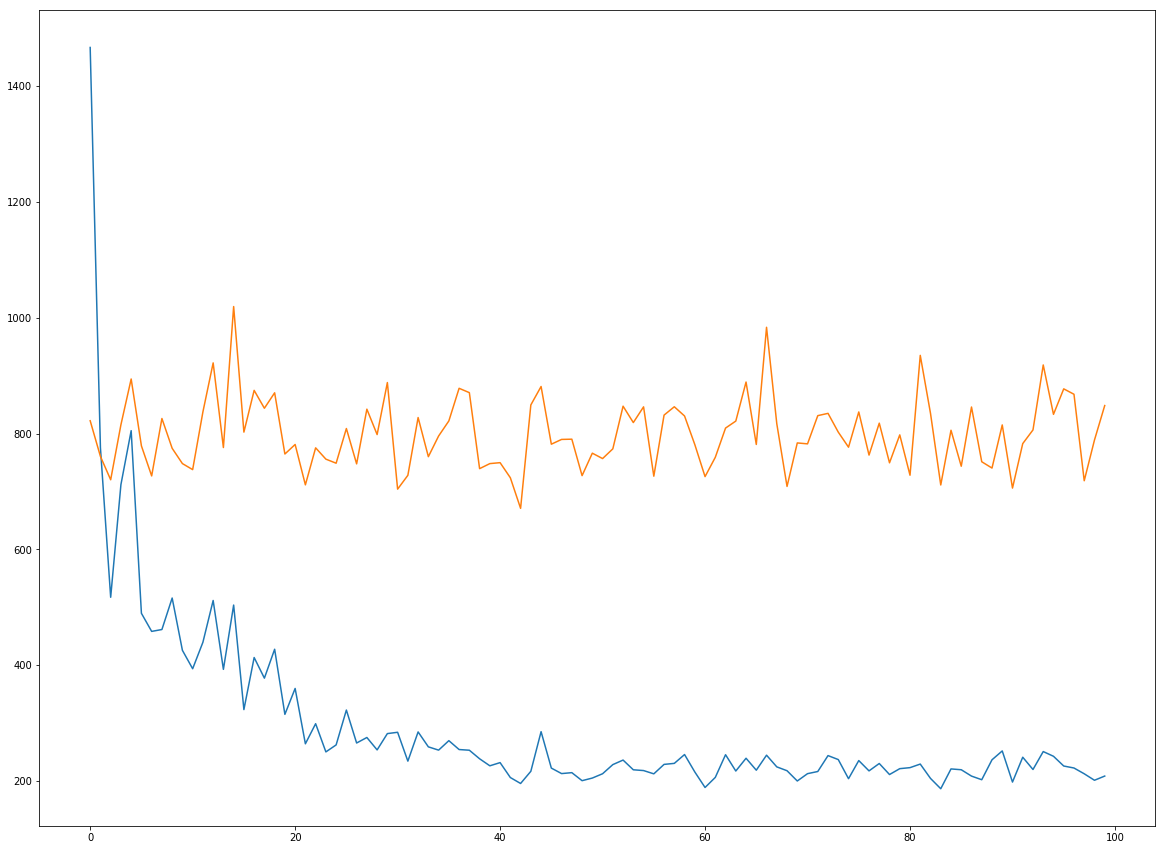

In [10]:
plt.figure(figsize=(20, 15))
plt.plot(model_losses)
plt.plot(baseline_losses)